# ML Data Leakage Detection Prototype

## End-to-End Pipeline with Explainable AI

This notebook demonstrates a comprehensive multi-modal data leakage detection system featuring:
- **Behavioral Anomaly Detection** (IsolationForest)
- **Document Classification** (Keyword/BERT-based)
- **Integrity Verification** (Hash + Semantic Similarity)
- **Risk Scoring & Fusion**
- **Explainable AI** (SHAP for behavior, LIME for text)

---

## Setup and Imports

In [22]:
import sys
import os

# Add parent directory to path
sys.path.append(os.path.dirname(os.getcwd()))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports successful")

✓ Imports successful


## Step 1: Data Generation

Generate synthetic user logs, documents, and tampered documents for testing.

In [23]:
# Import data generation module
sys.path.insert(0, '../data')
from generate_data import generate_user_logs, generate_documents

print("Generating synthetic data...\n")

# Generate user logs
print("1. Generating user logs...")
logs_df = generate_user_logs(n_users=50, n_logs_per_user=100)
logs_df.to_csv('../data/user_logs.csv', index=False)
print(f"   Generated {len(logs_df)} log entries for {logs_df['user_id'].nunique()} users")

# Generate documents
print("\n2. Generating documents...")
generate_documents()

print("\n✓ Data generation complete")

Generating synthetic data...

1. Generating user logs...
   Generated 5000 log entries for 50 users

2. Generating documents...
Generated 5 documents
Generated 2 tampered documents

✓ Data generation complete


## Step 2: Data Preprocessing

Create behavioral features from raw logs.

In [24]:
from preprocessing import create_log_features

print("Creating behavioral features...\n")
features_df = create_log_features(
    logs_path='../data/user_logs.csv',
    output_path='../data/log_features.csv'
)

print("\nFeature preview:")
display(features_df.head())

print("\n✓ Preprocessing complete")

Creating behavioral features...

Loading user logs...
Creating behavioral features...
Created 11 features for 50 users
Saved features to ../data/log_features.csv
Saved preprocessor to models/behavioral_preprocessor.pkl

Feature preview:


,user_id,user_data_volume_mb_mean,user_data_volume_mb_std,user_data_volume_mb_max,user_num_files_accessed_mean,user_num_files_accessed_std,user_session_duration_min_mean,user_session_duration_min_std,user_failed_logins_sum,unique_locations,unique_devices
0,U001,9.7159,7.167016,30.81,4.77,2.237671,26.3623,28.364186,0,3,3
1,U002,11.1082,7.419981,35.68,5.23,2.159569,32.0278,32.638249,0,3,3
2,U003,9.9322,6.828866,29.58,5.13,2.209507,29.6813,31.873281,0,3,3
3,U004,10.4415,6.954762,30.02,4.99,2.294019,32.6509,33.609418,0,3,3
4,U005,9.6399,6.104687,28.23,5.12,2.085447,31.2475,28.310506,0,3,3



✓ Preprocessing complete


## Step 3: Behavioral Anomaly Detection

Train IsolationForest model to detect unusual user behavior.

In [25]:
from anomaly_detection import train_and_evaluate

print("Training anomaly detection model...\n")
anomaly_results, detector = train_and_evaluate(
    features_path='../data/log_features.csv',
    output_path='../outputs/anomaly_results.csv'
)

print("\n✓ Anomaly detection complete")

Training anomaly detection model...

BEHAVIORAL ANOMALY DETECTION

1. Loading features...
Loaded 50 user records with 10 features

Features used: ['user_data_volume_mb_mean', 'user_data_volume_mb_std', 'user_data_volume_mb_max', 'user_num_files_accessed_mean', 'user_num_files_accessed_std', 'user_session_duration_min_mean', 'user_session_duration_min_std', 'user_failed_logins_sum', 'unique_locations', 'unique_devices']

2. Training IsolationForest model...
Trained IsolationForest with 100 estimators
Expected contamination rate: 0.1

3. Detecting anomalies...

Detected 5 anomalous users (10.0%)

Risk level distribution:
risk_level
low         25
medium      12
high         8
critical     5
Name: count, dtype: int64

Top 10 most anomalous users:
user_id  anomaly_score risk_level  is_anomaly
   U025      -0.685458   critical           1
   U043      -0.663490   critical           1
   U033      -0.651085   critical           1
   U023      -0.640214   critical           1
   U015      -0.

### Visualize Anomaly Results

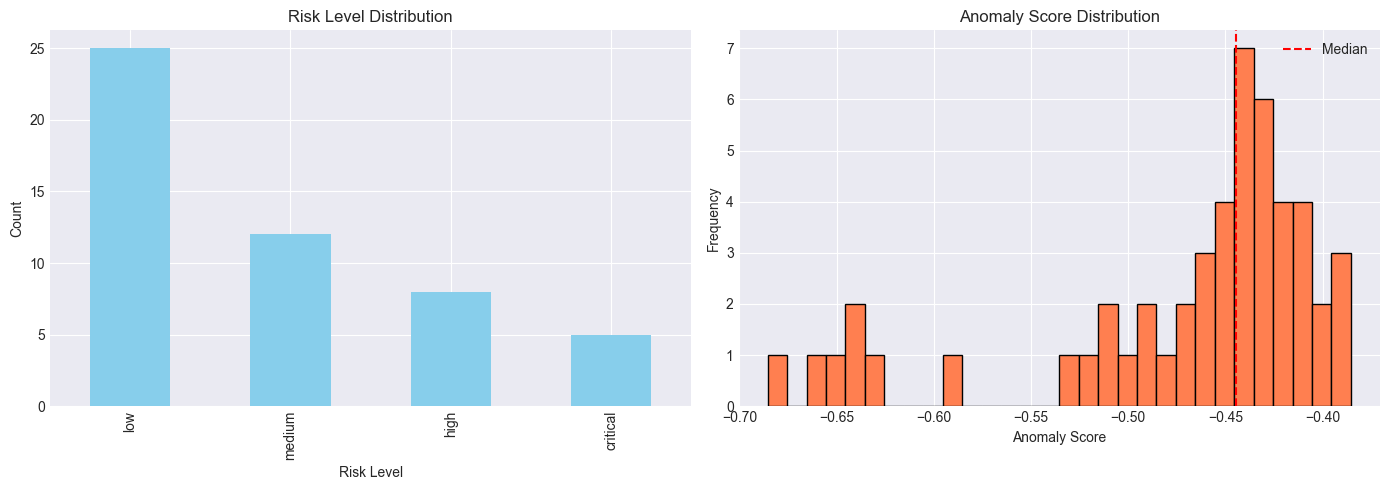

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Risk level distribution
anomaly_results['risk_level'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Risk Level Distribution')
axes[0].set_xlabel('Risk Level')
axes[0].set_ylabel('Count')

# Anomaly score distribution
axes[1].hist(anomaly_results['anomaly_score'], bins=30, color='coral', edgecolor='black')
axes[1].set_title('Anomaly Score Distribution')
axes[1].set_xlabel('Anomaly Score')
axes[1].set_ylabel('Frequency')
axes[1].axvline(anomaly_results['anomaly_score'].median(), color='red', linestyle='--', label='Median')
axes[1].legend()

plt.tight_layout()
plt.show()

## Step 4: Document Classification

Classify documents by sensitivity level (public/internal/confidential).

In [27]:
from document_classification import classify_and_evaluate

print("Classifying documents...\n")
classification_results, evaluation = classify_and_evaluate(
    doc_dir='../data/documents',
    output_path='../outputs/classification_results.csv',
    use_zero_shot=True  # Use keyword-based for speed by setting use_zero_shot=False
)

print("\n✓ Document classification complete")

Classifying documents...

DOCUMENT CLASSIFICATION
Initializing classifier with distilbert-base-uncased
Using device: CPU

Classifying documents in ../data/documents...
Method: Zero-shot BERT

Processing: customer_database.txt


Device set to use cpu


  -> Classified as: CONFIDENTIAL (confidence: 0.97)

Processing: finance_report.txt


Device set to use cpu


  -> Classified as: CONFIDENTIAL (confidence: 0.96)

Processing: hr_policy.txt


Device set to use cpu


  -> Classified as: INTERNAL (confidence: 0.56)

Processing: marketing_plan.txt


Device set to use cpu


  -> Classified as: INTERNAL (confidence: 0.92)

Processing: public_announcement.txt


Device set to use cpu


  -> Classified as: PUBLIC (confidence: 0.74)

CLASSIFICATION EVALUATION

Overall Accuracy: 100.00%

Per-document results:
               filename true_sensitivity predicted_sensitivity  confidence  correct
  customer_database.txt     confidential          confidential    0.968002        1
     finance_report.txt     confidential          confidential    0.961836        1
          hr_policy.txt         internal              internal    0.559272        1
     marketing_plan.txt         internal              internal    0.924069        1
public_announcement.txt           public                public    0.741675        1

Confusion Matrix:
Predicted     confidential  internal  public
True                                        
confidential             2         0       0
internal                 0         2       0
public                   0         0       1

Saving results to ../outputs/classification_results.csv...

CLASSIFICATION COMPLETE

✓ Document classification complete


### Visualize Classification Results

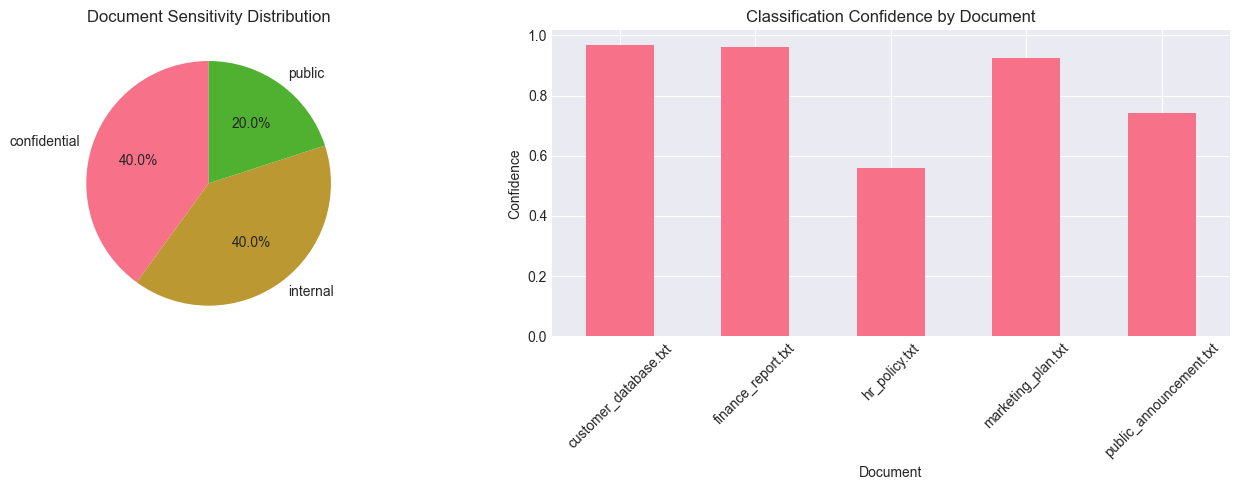

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sensitivity distribution
classification_results['predicted_sensitivity'].value_counts().plot(
    kind='pie', ax=axes[0], autopct='%1.1f%%', startangle=90
)
axes[0].set_title('Document Sensitivity Distribution')
axes[0].set_ylabel('')

# Confidence scores
classification_results.plot(x='filename', y='confidence', kind='bar', ax=axes[1], legend=False)
axes[1].set_title('Classification Confidence by Document')
axes[1].set_xlabel('Document')
axes[1].set_ylabel('Confidence')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Step 5: Integrity Verification

Check for document tampering using hash comparison.

In [29]:
from integrity_verification import verify_and_report

print("Verifying document integrity...\n")
integrity_results = verify_and_report(
    original_dir='../data/documents',
    tampered_dir='../data/tampered_docs',
    output_path='../outputs/integrity_results.csv',
    use_semantic=True  # Use hash-only for speed by setting use_semantic=False
)

print("\n✓ Integrity verification complete")

Verifying document integrity...

DOCUMENT INTEGRITY VERIFICATION
Loading sentence transformer model...
Model loaded successfully

Verifying documents from ../data/tampered_docs...

Verifying: customer_database.txt
  Hash Match: False
  Semantic Similarity: 0.947
  Status: MODIFIED
  Tamper Severity: MODERATE

Verifying: finance_report.txt
  Hash Match: False
  Semantic Similarity: 0.991
  Status: MODIFIED
  Tamper Severity: MINOR


Baseline verification of original documents...

Baseline: hr_policy.txt
  Status: INTACT

Baseline: marketing_plan.txt
  Status: INTACT

Baseline: public_announcement.txt
  Status: INTACT

VERIFICATION SUMMARY

Total documents verified: 5
Intact documents: 3
Tampered documents: 2

Tamper severity distribution:
  Moderate: 1
  Minor: 1

Tampered documents:
             filename integrity_status tamper_severity  semantic_similarity
customer_database.txt         modified        moderate             0.946520
   finance_report.txt         modified           minor

### Visualize Integrity Results

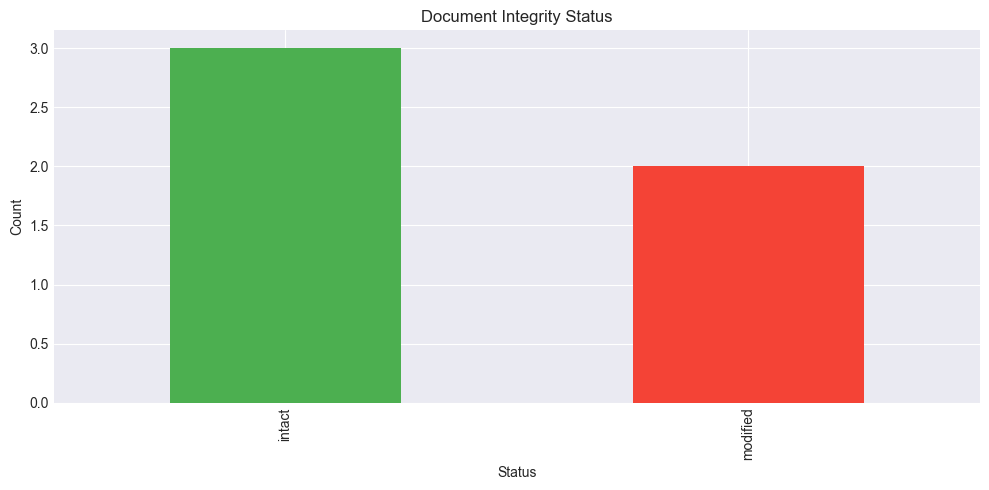


Tampered documents:


,filename,integrity_status,tamper_severity
0,customer_database.txt,modified,moderate
1,finance_report.txt,modified,minor


In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Integrity status
status_counts = integrity_results['integrity_status'].value_counts()
colors = ['#4caf50' if s == 'intact' else '#f44336' for s in status_counts.index]
status_counts.plot(kind='bar', ax=ax, color=colors)
ax.set_title('Document Integrity Status')
ax.set_xlabel('Status')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

# Show tampered documents
if integrity_results['tamper_detected'].sum() > 0:
    print("\nTampered documents:")
    display(integrity_results[integrity_results['tamper_detected']][[
        'filename', 'integrity_status', 'tamper_severity'
    ]])

## Step 6: Risk Scoring & Fusion

Combine all detection signals into unified risk scores.

In [31]:
from risk_scoring import fuse_results

print("Computing risk scores and generating alerts...\n")
risk_summary, alerts = fuse_results(
    anomaly_path='../outputs/anomaly_results.csv',
    classification_path='../outputs/classification_results.csv',
    integrity_path='../outputs/integrity_results.csv',
    output_path='../outputs/risk_summary.csv'
)

print("\n✓ Risk scoring complete")

Computing risk scores and generating alerts...

RISK SCORING AND FUSION

1. Loading detection results...
  Anomaly results: 50 users
  Classification results: 5 documents
  Integrity results: 5 documents
Risk scorer initialized with weights: {'behavior': 0.4, 'classification': 0.3, 'integrity': 0.3}

2. Computing user-level risk scores...

3. Computing document-level risk scores...

4. Generating alerts...

Generated 0 alerts:
  Critical: 0
  High: 0
  Medium: 0

Top 5 Alerts:
Empty DataFrame
Columns: [alert_id, entity_type, entity_id, risk_score, alert_priority]
Index: []

5. Saving results...
  Risk summary saved to ../outputs/risk_summary.csv
  Alerts saved to ../outputs/alerts.csv
  Statistics saved to ../outputs/risk_statistics.json

RISK SCORING COMPLETE

✓ Risk scoring complete


### Visualize Risk Scores

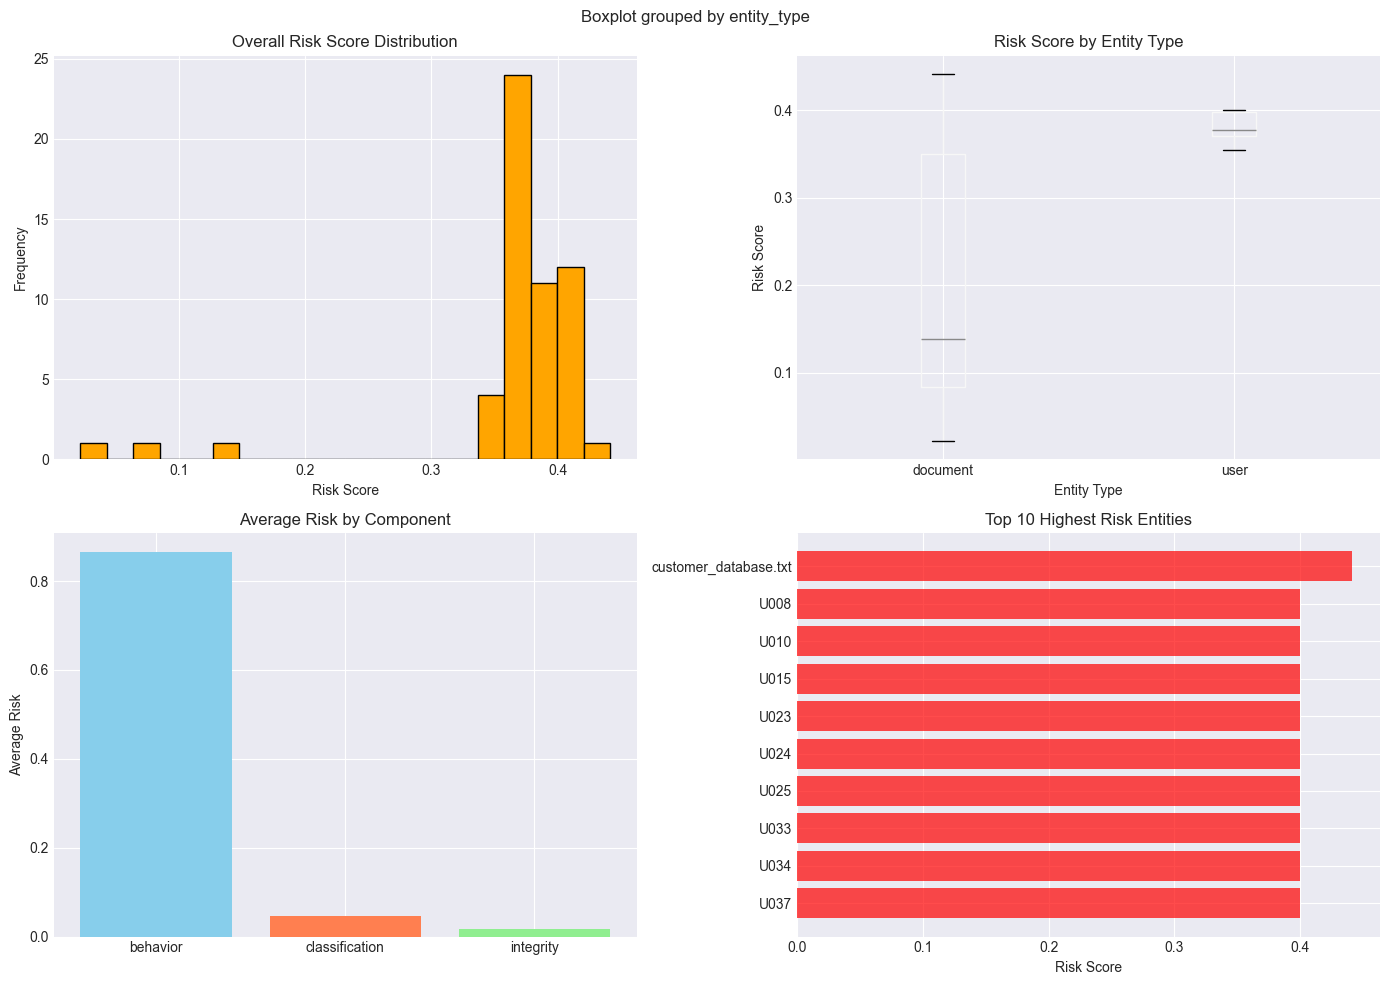

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Risk score distribution
axes[0, 0].hist(risk_summary['risk_score'], bins=20, color='orange', edgecolor='black')
axes[0, 0].set_title('Overall Risk Score Distribution')
axes[0, 0].set_xlabel('Risk Score')
axes[0, 0].set_ylabel('Frequency')

# Risk by entity type
risk_summary.boxplot(column='risk_score', by='entity_type', ax=axes[0, 1])
axes[0, 1].set_title('Risk Score by Entity Type')
axes[0, 1].set_xlabel('Entity Type')
axes[0, 1].set_ylabel('Risk Score')

# Risk component breakdown
components = ['behavior_risk', 'classification_risk', 'integrity_risk']
component_means = risk_summary[components].mean()
axes[1, 0].bar(range(len(components)), component_means.values, color=['skyblue', 'coral', 'lightgreen'])
axes[1, 0].set_xticks(range(len(components)))
axes[1, 0].set_xticklabels([c.replace('_risk', '') for c in components])
axes[1, 0].set_title('Average Risk by Component')
axes[1, 0].set_ylabel('Average Risk')

# Top 10 risks
top_10 = risk_summary.nlargest(10, 'risk_score')
axes[1, 1].barh(range(len(top_10)), top_10['risk_score'].values, color='red', alpha=0.7)
axes[1, 1].set_yticks(range(len(top_10)))
axes[1, 1].set_yticklabels(top_10['entity_id'].values)
axes[1, 1].set_title('Top 10 Highest Risk Entities')
axes[1, 1].set_xlabel('Risk Score')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

## Step 7: Explainable AI - SHAP for Behavioral Models

Generate SHAP explanations for behavioral anomaly detection.

**Note:** Requires `shap` package. Install with: `pip install shap`

Generating SHAP explanations...

SHAP EXPLAINABILITY FOR BEHAVIORAL DETECTION
Loading model...
Loading features...
Loaded 50 samples with 10 features

Creating SHAP explainer (method: tree)...
TreeExplainer created successfully

Computing SHAP values for all 50 samples...
SHAP values computed successfully

GENERATING VISUALIZATIONS

Generating SHAP summary plot...


c:\ML_DataLeakage_Prototype\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator ExtraTreeRegressor from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\ML_DataLeakage_Prototype\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator IsolationForest from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\ML_DataLeakage_Prototype\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.8.0 when using version 1.

Summary plot saved to xai_outputs/shap_summary_behavior.png

Generating explanations for top 5 anomalies...

1. User U015 (score: -0.755)

Generating force plot for U015...
Force plot saved to xai_outputs/shap_force_user_U015.png
  Top contributing features:
    - user_data_volume_mb_mean: decreases anomaly score (SHAP: -0.883)
    - user_data_volume_mb_max: decreases anomaly score (SHAP: -0.821)
    - user_num_files_accessed_std: decreases anomaly score (SHAP: -0.802)
    - user_data_volume_mb_std: decreases anomaly score (SHAP: -0.762)
    - user_num_files_accessed_mean: decreases anomaly score (SHAP: -0.749)

2. User U025 (score: -0.755)

Generating force plot for U025...
Force plot saved to xai_outputs/shap_force_user_U025.png
  Top contributing features:
    - user_data_volume_mb_mean: decreases anomaly score (SHAP: -0.889)
    - user_data_volume_mb_max: decreases anomaly score (SHAP: -0.886)
    - user_num_files_accessed_std: decreases anomaly score (SHAP: -0.786)
    - user_data

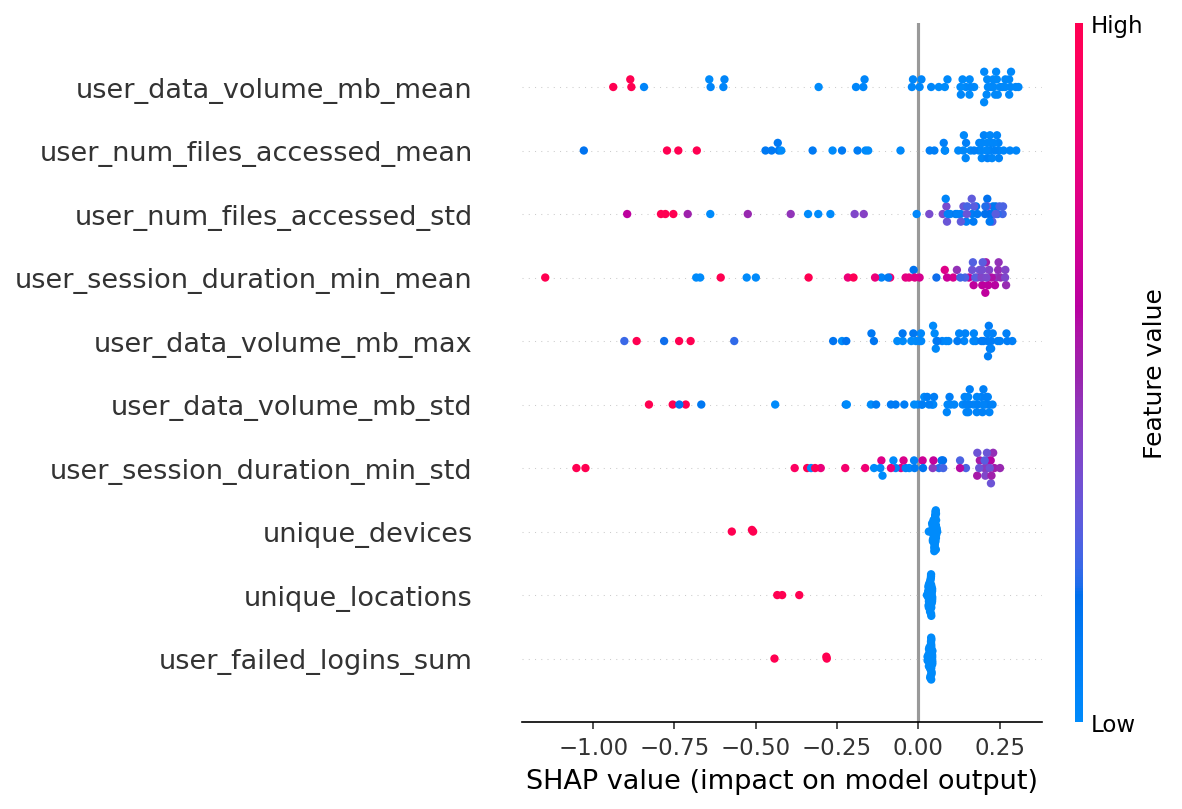

In [33]:
try:
    from explainability_shap import generate_shap_explanations
    
    print("Generating SHAP explanations...\n")
    shap_explainer = generate_shap_explanations(
        model_path='../models/isolation_forest.pkl',
        features_path='../data/log_features.csv',
        output_dir='../xai_outputs'
    )
    
    if shap_explainer:
        print("\n✓ SHAP explanations generated")
        
        # Display summary plot if available
        from IPython.display import Image as IPImage
        if os.path.exists('../xai_outputs/shap_summary_behavior.png'):
            display(IPImage(filename='../xai_outputs/shap_summary_behavior.png'))
    
except ImportError:
    print("⚠️ SHAP not installed. Skipping SHAP explanations.")
    print("Install with: pip install shap")

## Step 8: Explainable AI - LIME for Text Classification

Generate LIME explanations for document classification.

**Note:** Requires `lime` package. Install with: `pip install lime`

In [34]:
try:
    from explainability_lime import generate_lime_explanations
    
    print("Generating LIME explanations...\n")
    lime_results = generate_lime_explanations(
        doc_dir='../data/documents',
        output_dir='../xai_outputs/lime_text_explanations'
    )
    
    if lime_results:
        print("\n✓ LIME explanations generated")
        print(f"\nHTML explanations available in: ../xai_outputs/lime_text_explanations/")
    
except ImportError:
    print("⚠️ LIME not installed. Skipping LIME explanations.")
    print("Install with: pip install lime")

Generating LIME explanations...

LIME EXPLAINABILITY FOR DOCUMENT CLASSIFICATION
LIME explainer initialized
Class names: ['public', 'internal', 'confidential']

Generating LIME explanations for documents in ../data/documents...

Explaining: customer_database.txt
  Predicted: CONFIDENTIAL (confidence: 1.00)
  Top 5 influential words:
    'PII': -0.056 (pushes toward public)
    'GDPR': -0.050 (pushes toward public)
    'CONFIDENTIAL': -0.042 (pushes toward public)
    'CCPA': -0.031 (pushes toward public)
    '20': -0.021 (pushes toward public)
  HTML explanation saved to xai_outputs/lime_text_explanations\customer_database_explanation.html
  JSON explanation saved to xai_outputs/lime_text_explanations\customer_database_explanation.json

Explaining: finance_report.txt
  Predicted: CONFIDENTIAL (confidence: 1.00)
  Top 5 influential words:
    'Financial': -0.015 (pushes toward public)
    'Markets': -0.012 (pushes toward public)
    'Sensitive': -0.012 (pushes toward public)
    'confid

## Step 9: Summary & Dashboard

View summary statistics and launch the interactive dashboard.

In [35]:
print("="*60)
print("PROTOTYPE EXECUTION SUMMARY")
print("="*60)

print("\n📊 Detection Results:")
print(f"  - Anomalous users: {anomaly_results['is_anomaly'].sum()} / {len(anomaly_results)}")
print(f"  - Confidential documents: {len(classification_results[classification_results['predicted_sensitivity']=='confidential'])} / {len(classification_results)}")
print(f"  - Tampered documents: {integrity_results['tamper_detected'].sum()} / {len(integrity_results)}")
print(f"  - High-risk entities: {len(risk_summary[risk_summary['risk_score'] >= 0.6])} / {len(risk_summary)}")
print(f"  - Active alerts: {len(alerts)}")

print("\n📁 Output Files:")
output_files = [
    'outputs/anomaly_results.csv',
    'outputs/classification_results.csv',
    'outputs/integrity_results.csv',
    'outputs/risk_summary.csv',
    'outputs/alerts.csv'
]
for file in output_files:
    status = "✓" if os.path.exists(f"../{file}") else "✗"
    print(f"  {status} {file}")

print("\n🎯 Next Steps:")
print("  1. Review results in the output files")
print("  2. Launch the interactive dashboard: streamlit run dashboard/app.py")
print("  3. Install SHAP and LIME for XAI features (optional)")
print("     - pip install shap lime")

print("\n" + "="*60)
print("✓ PROTOTYPE COMPLETE")
print("="*60)

PROTOTYPE EXECUTION SUMMARY

📊 Detection Results:
  - Anomalous users: 5 / 50
  - Confidential documents: 2 / 5
  - Tampered documents: 2 / 5
  - High-risk entities: 0 / 55
  - Active alerts: 0

📁 Output Files:
  ✓ outputs/anomaly_results.csv
  ✓ outputs/classification_results.csv
  ✓ outputs/integrity_results.csv
  ✓ outputs/risk_summary.csv
  ✓ outputs/alerts.csv

🎯 Next Steps:
  1. Review results in the output files
  2. Launch the interactive dashboard: streamlit run dashboard/app.py
  3. Install SHAP and LIME for XAI features (optional)
     - pip install shap lime

✓ PROTOTYPE COMPLETE


## Launch Dashboard

To launch the interactive Streamlit dashboard, run the following command in your terminal:

```bash
streamlit run dashboard/app.py
```

Or execute the cell below (may not work in all notebook environments):

In [36]:
# Uncomment to launch dashboard from notebook (may require additional setup)
# !streamlit run ../dashboard/app.py